### Packages to be installed

In [1]:
# !pip install emoji

### Importing Packages

In [2]:
# https://www.kaggle.com/crowdflower/twitter-user-gender-classification/kernels

# To access directories and files
import os

# To read XML file content
from xml.dom import minidom

# To store id, gender and content
import pandas as pd

# import regex library
import re

import emoji # importing the emoji package to check for emoji characters

# importing spacy package
import spacy
import time # using this to keep a track of our runtime

# importing numpy package
import numpy as np

# importing probability functions from nltk package to calculate frequncy distributions
from nltk.probability import *
# importing the list of stopwords from nltk corpus
from nltk.corpus import stopwords

import string

# import the metrics class
from sklearn import metrics

# the Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
# function to split the data for cross-validation
from sklearn.model_selection import train_test_split
# function for transforming documents into counts
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# function for encoding categories
from sklearn.preprocessing import LabelEncoder

# importing the different classification model classes from sklearn
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import SVC, LinearSVC

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# importing the libraries for plotting graphs
import seaborn as sns
import matplotlib.pyplot as plt

# importing the functions to help us calculte the metrics of individual models
from sklearn.model_selection import cross_val_score

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, matthews_corrcoef

### Reading all the given data

We are provided with a list of xml files each containing twitter posts from multiple authors belonging to different gender classes. So, firstly using `minidom` to extract the `post content` from the xml files and then adding it along with its respective `document id` to a `dataframe` for easy use. Then reading the `train_labels.csv` file and extracting out the `document id` along with the `gender` class that particular document belongs to. Finally, merging the two newly created dataframes into one containing, `id`, `content` and	`gender`.

#### XML

In [3]:
# Initialising base path where all XML files are present 
# basePath = 'Assessment2_data\\Assessment2_data\\data\\data'
basePath = 'data\\data'

# Storing all the XML files present in the directory
files = [file for file in os.listdir(basePath) if file.endswith(".xml")]

# Initialising a list to store content from all the files
content = []

# Creating a dataframe to store id and content
contentDF = pd.DataFrame(columns=["id", "content"])

# Traverse through all files
for file in files:
    # Access XML file
    xmlDoc = minidom.parse(os.path.join(basePath, file))

    # Traverse based on the tag document
    documentList = xmlDoc.getElementsByTagName('document')
    
    # Initialising docLines string to store all document content from a specific file
    docLines = ""

    # Print each line within the tag document
    for document in documentList:
        docLines = docLines + document.firstChild.data
    
    # Assigning values of id and content columns to a new row
    newRow = {'id':file[:len(file)-4], 'content':docLines}
    
    # Appending a new row to the dataframe
    contentDF = contentDF.append(newRow, ignore_index=True)
    
# Total documents' content 
print(len(contentDF))

# Displaying the content from all the files 
contentDF.head()

3600


,id,content
0,1003de26f870d27f79887272a1eb3612,One to watch … \nAvailable on 10th Feb. https:...
1,102cce280df9f6e0e78bfdd266f1abb5,Are we living in a holographic universe? New s...
2,10488b3700fa9d2db22961ab064e4d38,"Museum focus, but still great pieces of advice..."
3,1064bd0b78f14bea5b851e2a995dd4e5,Best half time show EVER!@jannarden not the e...
4,106aa0abb81873d09028b01658c37611,Does this mean @WaitakereUnited are top of the...


#### CSV

In [4]:
# Reading the train data 
trainData = pd.read_csv("train_labels.csv")

# Displaying first few rows from train set 
trainData.head()

,id,gender
0,d7d392835f50664fc079f0f388e147a0,male
1,ee40b86368137b86f51806c9f105b34b,female
2,919bc742d9a22d65eab1f52b11656cab,male
3,15b97a08d65f22d97ca685686510b6ae,female
4,affa98421ef5c46ca7c8f246e0a134c1,female


#### Merging the content into a single dataframe

In [5]:
# Merging the contentDF and trainDataDF into trainContentDF based on id 
trainContentDF = pd.merge(contentDF, trainData, on='id', how='inner')

# Total training documents with gender content 
print(len(trainContentDF))

# Displaying the first few rows from trainContentDF
trainContentDF.head()

3100


,id,content,gender
0,1003de26f870d27f79887272a1eb3612,One to watch … \nAvailable on 10th Feb. https:...,male
1,102cce280df9f6e0e78bfdd266f1abb5,Are we living in a holographic universe? New s...,female
2,10488b3700fa9d2db22961ab064e4d38,"Museum focus, but still great pieces of advice...",female
3,106aa0abb81873d09028b01658c37611,Does this mean @WaitakereUnited are top of the...,male
4,1074ea46e0f2d49b18b4d77b9aa8c9b,in the time of chimpanzees I was a monkeyHow o...,male


# Preprocessing

#### Replacing double or more spaces with a single space

In [6]:
for index in range(len(trainContentDF)):
    
    text = trainContentDF.at[index, 'content']  # extracting the content out from the dataframe at that particular index
    
    text = re.sub('\s+', ' ', text)  # using regex to remove extra spaces
    
    trainContentDF.at[index, 'content'] = text  # placing the formatted content back into that specific index

#### Creating a new column

We want to keep our `content` intact and make all the changes on the new column `tokencontent`

In [7]:
trainContentDF['tokencontent'] = ""
trainContentDF

,id,content,gender,tokencontent
0,1003de26f870d27f79887272a1eb3612,One to watch … Available on 10th Feb. https://...,male,
1,102cce280df9f6e0e78bfdd266f1abb5,Are we living in a holographic universe? New s...,female,
2,10488b3700fa9d2db22961ab064e4d38,"Museum focus, but still great pieces of advice...",female,
3,106aa0abb81873d09028b01658c37611,Does this mean @WaitakereUnited are top of the...,male,
4,1074ea46e0f2d49b18b4d77b9aa8c9b,in the time of chimpanzees I was a monkeyHow o...,male,
...,...,...,...,...
3095,ffa27eef9a46f4d6b3e2c0ff3131936f,@Predictive_Hire thanks for following👍@lawrenc...,male,
3096,ffa8289a14683e00a607a2d9bb5d1367,@LauraAnthony7 @UCBerkeley eooks likes lynch m...,female,
3097,ffbd53773c792831d5b6322b775faa3a,@groubes such a classy player! Was awesome to ...,male,
3098,ffc349a1e4c9a3b37fd8798e82d703a2,Great weekend spent with family! Thoroughly en...,male,


#### Adding a space before every @ and emoji to split bunched up multiple emojis and tags

We want a record of all the tagged personalities along with any emoji characters used. So, before we move on to any form of preprocessing we are first formatting our data accordingly. We are adding space before and after any `emoji` we get, as we can get the `individual emojis` with its `actual count`. Then also adding a space before `@` characters because while splitting tokens based on spaces, if there are multiple words beginning with `@` then it concatenates all the simultaneous occurences of those words into one token. 

In [8]:
for index in range(len(trainContentDF)):
    
    # getting the content out from every index
    content = trainContentDF.at[index, 'content']
    
    filteredContent = ""
    for each in content:
        if each in emoji.UNICODE_EMOJI:
            # adding spaces before and after every emoji occurence
            filteredContent += ' ' + each + ' '
        elif each == '@':
            # adding a space before each @ occurence
            filteredContent += ' ' + each
        else:
            # else adding every content
            filteredContent += each
    
    # replacing new line characters with space
    filteredContent = re.sub('\n', ' ', filteredContent).split()
    
    # adding the formatted data into the newly created column above
    trainContentDF.at[index, 'tokencontent'] = filteredContent

#### Splitting the training data set into separate datasets with male authors in one and female in the other

In [9]:
trainMaleDFsubset = trainContentDF[trainContentDF['gender']=='male']
trainFemaleDFsubset = trainContentDF[trainContentDF['gender']=='female']

#### Function that checks for an email

In [10]:
def is_valid_email(email):
    return bool(re.match("[A-Z0-9a-z._-]+@[A-Za-z0-9]+\.[A-Za-z0-9]{2,}", email))

#### Creating a list of lists containing the words used by males

In [11]:
maleContent = trainMaleDFsubset['tokencontent'].tolist()

#### This is a 2D list

In [12]:
len(maleContent)

1552

#### Flattening it to a 1D list

In [13]:
flatMaleContent = [item for sublist in maleContent for item in sublist]

In [14]:
# removing numeric characters and punctuations that are occuring by themselves
flatMaleContent = [i for i in flatMaleContent if not all(j.isdigit() or j in string.punctuation for j in i)]

#### Tagging emails as email

In [15]:
maleContentList = []
emailIDMale = 0
for each in flatMaleContent:
    each = each.lower()
    if is_valid_email(each):
        maleContentList.append('email')
        emailIDMale += 1
    else:
        maleContentList.append(each)

#### Tagging html links and emojis

Since the machine would not be able to read and understand the http links and emojis, so if any token has `http` then converting it into `weblink` and converting any `emoji` character belonging to `emoji.UNICODE_EMOJI` into `emoji`. 

Extracting the word occurring after `#` and appending that into the list.

Removing any unwanted tokens like `&gt;` from the content as well.

In [16]:
maleListWithTags = []
taggedMale = 0
hashedMale = 0
for each in maleContentList:
    each = each.lower()
    # adding weblink as tag for http:
    if each[:4] == 'http':
        maleListWithTags.append('weblink')
    # adding emoji as tag
    elif each in emoji.UNICODE_EMOJI:
        maleListWithTags.append('emoji')
    # Extracting the word occurring after @
    elif each[:1] == '@' and len(each) > 1:
        maleListWithTags.append(each[1:])
        taggedMale += 1
    # Extracting the word occurring after # 
    elif each[:1] == '#' and len(each) > 1:
        maleListWithTags.append(each[1:])
        hashedMale += 1
    # adding tokens that are not of the form &gt; which basically means add every other word
    elif not (each[:1] == '&' and each[-1:] == ';'):
        maleListWithTags.append(each)
        

#### Removing Punctuations

In [17]:
maleListFinal = []
for each in maleListWithTags:
    # using the punctuation function in the string library to remove all punctuations
    each = each.translate(str.maketrans('', '', string.punctuation))
    maleListFinal.append(each)


#### Removing weird symbols and words shorter than 3 characters long

In [18]:
sortOfmaleListFinal = []
# removing weird symbols found while going through the dataset that were not being removed while preprocessing
for each in maleListFinal:
    each = re.sub('’','', each)
    each = re.sub('༼ノಠل͟ಠ༽ノ︵┻━┻','', each)
    each = re.sub(r'\d+', '', each)
    sortOfmaleListFinal.append(each)
sortOfmaleListFinal = [i for i in sortOfmaleListFinal if len(i) > 2]

In [19]:
print(emailIDMale, taggedMale, hashedMale)

0 124570 50456


#### Doing the same preprocessing for the dataset separated out for `gender =  female`

In [20]:
femaleContent = []
# iterating through the content for each row and adding it to a list
for index, row in trainFemaleDFsubset.iterrows():
    femaleContent.append(row['tokencontent'])

# flattening the 2D list into a 1D list
flatFemaleContent = [item for sublist in femaleContent for item in sublist]
# removing numeric characters and punctuations that are occuring by themselves
flatFemaleContent = [i for i in flatFemaleContent if not all(j.isdigit() or j in string.punctuation for j in i)]

femaleContentList = []
emailIDFemale = 0
for each in flatFemaleContent:
    each = each.lower()
    if is_valid_email(each):
        femaleContentList.append('email')
        emailIDFemale += 1
    else:
        femaleContentList.append(each)
        
femaleListWithTags = []
taggedFemale = 0
hashedFemale = 0
for each in femaleContentList:
    each = each.lower()
    # adding weblink as tag for http:
    if each[:4] == 'http':
        femaleListWithTags.append('weblink')
    # adding emoji as tag
    elif each in emoji.UNICODE_EMOJI:
        femaleListWithTags.append('emoji')
    # Extracting the word occurring after @
    elif each[:1] == '@' and len(each) > 1:
        femaleListWithTags.append(each[1:])
        taggedFemale += 1
    # Extracting the word occurring after # 
    elif each[:1] == '#' and len(each) > 1:
        femaleListWithTags.append(each[1:])
        hashedFemale += 1
    # adding tokens that are not of the form &gt; which basically means add every other word
    elif not (each[:1] == '&' and each[-1:] == ';'):
        femaleListWithTags.append(each)

femaleListFinal = []
for each in femaleListWithTags:
    # using the punctuation function in the string library to remove all punctuations
    each = each.translate(str.maketrans('', '', string.punctuation))
    femaleListFinal.append(each)
    
sortOfFemaleListFinal = []
# removing weird symbols found while going through the dataset that were not being removed while preprocessing
for each in femaleListFinal:
    each = re.sub('’','', each)
    each = re.sub('༼ノಠل͟ಠ༽ノ︵┻━┻','', each)
    each = re.sub('…','', each)
    each = re.sub(r'\d+', '', each)
    sortOfFemaleListFinal.append(each)

# removing all characters pf length less than 2
sortOfFemaleListFinal = [i for i in sortOfFemaleListFinal if len(i) > 2]

In [21]:
print(emailIDFemale, taggedFemale, hashedFemale)

0 109919 65877


In [22]:
print(len(sortOfmaleListFinal), len(sortOfFemaleListFinal))

1689228 1656846


#### Calculating the `frequency distribution` for each gender list to get an overview of the word distribution used by each gender category

In [23]:
freqDistMale = FreqDist(sortOfmaleListFinal)
freqDistFemale = FreqDist(sortOfFemaleListFinal)

In [24]:
freqDistMale

FreqDist({'weblink': 70982, 'the': 67708, 'and': 26838, 'emoji': 24071, 'for': 23494, 'you': 20425, 'that': 14346, 'this': 13695, 'with': 11665, 'not': 9339, ...})

In [25]:
freqDistFemale

FreqDist({'weblink': 73575, 'the': 55692, 'emoji': 51305, 'and': 27819, 'for': 26226, 'you': 25131, 'this': 15215, 'that': 12216, 'with': 11314, 'have': 9645, ...})

From the above output we can see the difference in the number of emojis used between the 2 gender categories. Visualizing the the output below by plotting two separate graphs.

#### Top frequent words for males and females

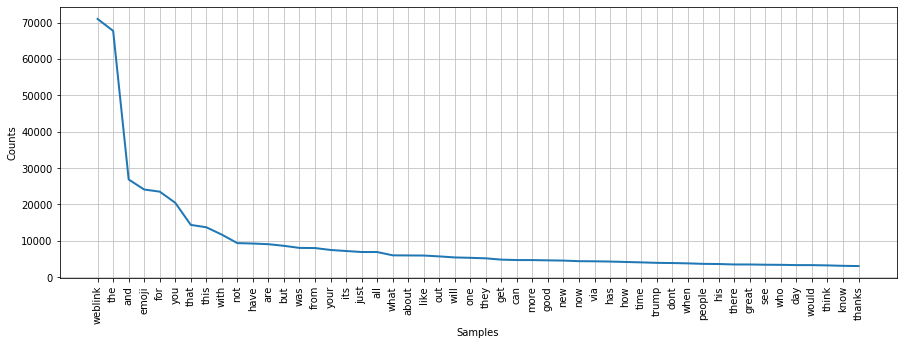

In [26]:
plt.figure(figsize=(15,5))
freqDistMale.plot(50,cumulative=False)
plt.show()

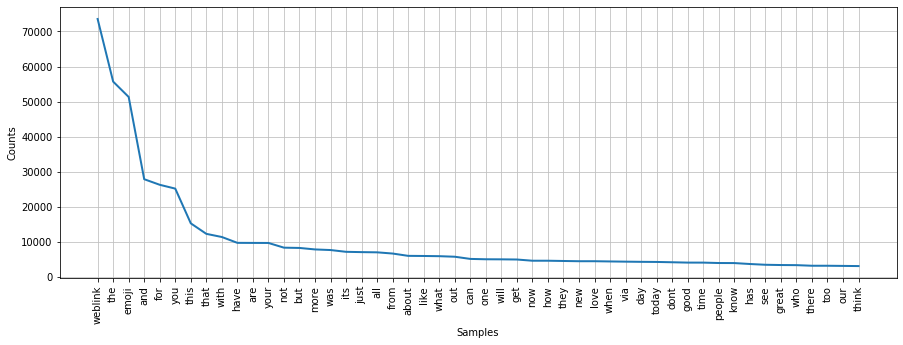

In [27]:
plt.figure(figsize=(15,5))
freqDistFemale.plot(50,cumulative=False)
plt.show()

From the above visualization we can clearly infer that we can remove almost all the stopwords from the content list. There are some tokens which occur more for a particular gender.

## Applying the above preprocessing on the complete training data

In [28]:
# storing the stopwords list in a variable
stop_words_en = list(stopwords.words('english'))

In [29]:
for index in range(len(trainContentDF)):
    
    # taking individual row content out into a variable
    text = trainContentDF.at[index, 'tokencontent']
    
    filteredContent = []  # a dummy list variable to easily work with the data
    
    for each in text:
        # converting every variable into lowercase
        each = each.lower()
        # adding weblink as tag for http:
        if each[:4] == 'http':
            filteredContent.append('weblink')
        # adding emoji as tag
        elif each in emoji.UNICODE_EMOJI:
            filteredContent.append('emoji')
        # not adding the tagged content 
        elif each[:1] == '@' and len(each) > 1:            
            pass
        # not adding the hashed content 
        elif each[:1] == '#' and len(each) > 1:
            pass
        # adding tokens that are not of the form &gt; which basically means add every other word
        elif not (each[:1] == '&' and each[-1:] == ';'):
            filteredContent.append(each)
            
    content = []
    
    # removing any remaining punctuations or weird symbols found while going through the dataset that were not being removed while preprocessing
    for each in filteredContent:
        each = each.translate(str.maketrans('', '', string.punctuation))
        each = re.sub('’','', each)
        each = re.sub('༼ノಠل͟ಠ༽ノ︵┻━┻','', each)
        each = re.sub('…','', each)
        each = re.sub(r'\d+', '', each)
        content.append(each)
    
    # removing all characters pf length less than 2
    content = [i for i in content if len(i) > 2]
    # removing all stopwords
    content = [i for i in content if i not in stop_words_en]
    
    # converting the list back into a string
    content = " ".join(content)
    
    # adding it back to its respective index position
    trainContentDF.at[index, 'tokencontent'] = content

# Feature Extraction

#### Defining Stop Words and Vectorizer

In [30]:
nlp = spacy.load('en_core_web_sm')

# Defining a LemmaTokenizer using Spacy to be used later whie vectoring the abstract
class LemmaTokenizerSpacy(object):        
    def __call__(self,doc):
        trydoc = nlp(doc)
        return [token.lemma_ for token in trydoc]

#### Function to transform the given text into a feature matrix

In [31]:
def fitter(vectorizer, tokenContent):
    
    return vectorizer.fit_transform(tokenContent)


#### Functions to transform the Gender labels into 1s and 0s

In [32]:
def labEncoder(gender):
    
    encoder = LabelEncoder()
    
    return encoder.fit_transform(gender)


# Cross Validation

In [33]:
def crossValidator(x, y, CV = 10, alg = 'LR'):

    CVDF = pd.DataFrame(index = range(CV))

    entries = []

    if alg == 'LR':

        model = LogisticRegression()
        modelName = 'Logistic Regression'

    elif alg == 'SVC':

        model = LinearSVC()
        modelName = 'Linear SVC'


    elif alg == 'NB':

        model = MultinomialNB()
        modelName = 'Naive Bayes'
        
    
    accuracies = cross_val_score(model, x, y, scoring = 'accuracy', cv = CV)

    for foldID, accuracy in enumerate(accuracies):

        entries.append((modelName, foldID, accuracy))

    CVDF = pd.DataFrame(entries, columns = ['ModelName', 'FoldID', 'Accuracy'])

    return CVDF



# Classification

In [34]:
def classifier(x, y, alg = 'LR'):
    
    if alg == 'LR':

        model = LogisticRegression()
        modelName = 'Logistic Regression'

    elif alg == 'SVC':

        model = SVC(C=10, gamma=0.7, kernel='rbf')
        modelName = 'SVC'
        
    elif alg == 'LinearSVC':

        model = LinearSVC(C=10)
        modelName = 'Linear SVC'

    elif alg == 'NB':

        model = MultinomialNB()
        modelName = 'Naive Bayes'
    
    xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.2)

    model.fit(xTrain, yTrain)

    yPredict = model.predict(xTest)

    accuracy = accuracy_score(yTest, yPredict)

    MCC = matthews_corrcoef(yTest, yPredict)

    cfnMatrix = confusion_matrix(yTest, yPredict)

    return cfnMatrix, accuracy, MCC

# Feature Generation

In [35]:
startTime = time.time()

In [36]:
trainContentDF

,id,content,gender,tokencontent
0,1003de26f870d27f79887272a1eb3612,One to watch … Available on 10th Feb. https://...,male,one watch available feb weblink complete sets ...
1,102cce280df9f6e0e78bfdd266f1abb5,Are we living in a holographic universe? New s...,female,living holographic universe new study suggests...
2,10488b3700fa9d2db22961ab064e4d38,"Museum focus, but still great pieces of advice...",female,museum focus still great pieces advice museums...
3,106aa0abb81873d09028b01658c37611,Does this mean @WaitakereUnited are top of the...,male,mean top league guys bailed tho weblink badthi...
4,1074ea46e0f2d49b18b4d77b9aa8c9b,in the time of chimpanzees I was a monkeyHow o...,male,time chimpanzees monkeyhow earth foulwere back...
...,...,...,...,...
3095,ffa27eef9a46f4d6b3e2c0ff3131936f,@Predictive_Hire thanks for following👍@lawrenc...,male,thanks following emoji thanks followingso thin...
3096,ffa8289a14683e00a607a2d9bb5d1367,@LauraAnthony7 @UCBerkeley eooks likes lynch m...,female,eooks likes lynch mob kkk conservativegayimmig...
3097,ffbd53773c792831d5b6322b775faa3a,@groubes such a classy player! Was awesome to ...,male,classy player awesome see action congrats grea...
3098,ffc349a1e4c9a3b37fd8798e82d703a2,Great weekend spent with family! Thoroughly en...,male,great weekend spent family thoroughly enjoyed ...


### Generating features using `TF-IDF Vectorizer`

`TF-IDF`, also known as `Term Frequency-Inverse Document Frequency`, will consider all the tokens that we
pass into it. TF-IDF refers to the frequency of a token occurring in each twitter post (term frequency)
and the number of documents in which that particular token exists (inverse document frequency). It
makes sure that tokens which occur frequently in a document and which occur in the majority of the
documents be penalized. It allows us to extract features that might be important for increasing
model classifying accuracy.

Using `LemmaTokenizerSpacy()` function provided by `Spacy` that takes care of `lemmatizing` and `tokenizing` the tokens for it to be passed into the models

In [37]:
TFIDF = TfidfVectorizer(analyzer='word',input='content',
                           lowercase = True,  # will lowercase all the tokens
                           min_df = 8,  # will remove tokens that occurs in less than the number of documents specified
                           max_df = 0.5,  #  will remove tokens that occur too frequently
                           ngram_range =(1,2),  #  considering both unigrams and bigrams
                           tokenizer=LemmaTokenizerSpacy())  

# transforming the content using the TFIDF vectorizer
textFeature = TFIDF.fit_transform(trainContentDF['tokencontent'])

# encoding the gender labels
labels = labEncoder(trainContentDF['gender'])

# running croos-validation to get an idea of what values to expect
CVresults = crossValidator(textFeature, labels, CV = 10, alg = 'LR')

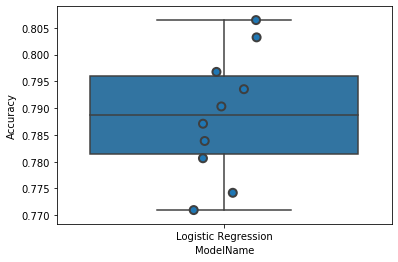

In [38]:
# plotting the cross-validation accuracy values
sns.boxplot(x = 'ModelName', y = 'Accuracy', data = CVresults)
sns.stripplot(x = 'ModelName', y = 'Accuracy', data = CVresults, size = 8, jitter = True, edgecolor = "gray", linewidth = 2)
plt.show()

In [39]:
# calculating the confusion matrix, accuracy score and MCC Score
conMatrix, accuracy, MCC = classifier(textFeature, labels, alg = 'LR')

# displaying the found values
print(conMatrix)
print(accuracy)
print(MCC)

[[258  63]
 [ 62 237]]
0.7983870967741935
0.5963152255450112


# Test Data

### Final Run on Test Data

#### Performing the same Preprocessing steps for Test Data (Same steps as Train Data)

In [40]:
# Reading the train data 
testData = pd.read_csv("test_labels.csv")

# Merging the contentDF and trainDataDF into trainContentDF based on id 
testContentDF = pd.merge(contentDF, testData, on='id', how='inner')

# Total training documents with gender content 
print(len(testContentDF))

# Displaying the first few rows from trainContentDF
testContentDF.head()

testContentDF['tokencontent'] = ""

for i in range(len(testContentDF)):
    
    content = testContentDF.at[i, 'content']  # getting the content out from every index
    
    filteredContent = ""
    for each in content:
        if each in emoji.UNICODE_EMOJI:
            # adding spaces before and after every emoji occurence
            filteredContent += ' ' + each + ' '
        elif each == '@':
            # adding a space before each @ occurence
            filteredContent += ' ' + each
        else:
            # else adding every content
            filteredContent += each
    
    # replacing new line characters with space
    filteredContent = re.sub('\n', ' ', filteredContent)
    
    # adding the formatted data into the newly created column above
    testContentDF.at[i, 'tokencontent'] = filteredContent
    
    

500


In [41]:
for index in range(len(testContentDF)):
    
    text = testContentDF.at[index, 'tokencontent']  # taking individual row content out into a variable
    
    text = text.split()
    
    filteredContent = []  # # a dummy list variable to easily work with the data
    
    for each in text:
        # converting every variable into lowercase
        each = each.lower()
        # adding weblink as tag for http:
        if each[:4] == 'http':
            filteredContent.append('weblink')
        # adding emoji as tag
        elif each in emoji.UNICODE_EMOJI:
            filteredContent.append('emoji')
        # not adding the tagged content 
        elif each[:1] == '@' and len(each) > 1:
            pass
        # not adding the hashed content 
        elif each[:1] == '#' and len(each) > 1:
            pass
        # adding tokens that are not of the form &gt; which basically means add every other word
        elif not (each[:1] == '&' and each[-1:] == ';'):
            filteredContent.append(each)
            
    content = []
    
    # removing any remaining punctuations or weird symbols found while going through the dataset that were not being removed while preprocessing
    for each in filteredContent:
        each = each.translate(str.maketrans('', '', string.punctuation))
        each = re.sub('’','', each)
        each = re.sub('༼ノಠل͟ಠ༽ノ︵┻━┻','', each)
        each = re.sub('…','', each)
        each = re.sub(r'\d+', '', each)
        content.append(each)
    
    # removing all characters pf length less than 2
    content = [i for i in content if len(i) > 2]
    
    # removing all stopwords
    content = [i for i in content if i not in stop_words_en]
    
    # converting the list back into a string
    content = " ".join(content)
    
    # adding it back to its respective index position
    testContentDF.at[index, 'tokencontent'] = content

# Generating the final model

In [42]:
# encoding the gender labels
testLabels = labEncoder(testContentDF['gender'])

In [43]:
# transforming the content using the TFIDF vectorizer
testFeature = TFIDF.transform(testContentDF['tokencontent'])

In [44]:
# setting the final model as Logistic Regression
finalModelLR = LogisticRegression()

finalModelLR.fit(textFeature, labels)  # fitting the training data and its labels to train the model

finalPredictionsLR = finalModelLR.predict(testFeature)  # using the model to predict the test labels

# calculating the confusion matrix, accuracy score and MCC Score
finalAccuracyLR = accuracy_score(testLabels, finalPredictionsLR)

finalMCCLR = matthews_corrcoef(testLabels, finalPredictionsLR)

finalConMatrixLR = confusion_matrix(testLabels, finalPredictionsLR)


#### Logistic Regression

In [45]:
# displaying the found values
print(finalConMatrixLR)
print(finalAccuracyLR)
print(finalMCCLR)

[[198  54]
 [ 38 210]]
0.816
0.6334622881214946


## Exporting the final dataset out as `testSolution`

In [46]:
testSolution = testContentDF.drop(columns = ['content', 'tokencontent'])

testSolution['gender'] = finalPredictionsLR

genderDict = {1: 'male', 0: 'female'}

testSolution.gender = [genderDict[item] for item in testSolution.gender]

In [47]:
testSolution.to_csv('testSolution.csv', index=False)